In [268]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

from scipy import stats
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri           # for using R functions
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
numpy2ri.activate()
pandas2ri.activate()

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

In [89]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
msp_mandi = pd.read_csv('CMO_MSP_Mandi.csv')

In [3]:
msp_mandi.shape

(155, 5)

In [4]:
msp_mandi.head()

,commodity,year,Type,msprice,msp_filter
0,PADDY-UNHUSKED,2012,Kharif Crops,1250.0,1
1,RICE(PADDY-HUS),2012,Kharif Crops,1280.0,1
2,Jowar_Hybrid,2012,Kharif Crops,1500.0,1
3,SORGUM(JAWAR),2012,Kharif Crops,1520.0,1
4,BAJRI,2012,Kharif Crops,1175.0,1


In [5]:
data = pd.read_csv('Monthly_data_cmo.csv')

In [6]:
data.shape

(62429, 11)

In [7]:
data.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name
0,Ahmednagar,Bajri,2015,April,79,1406,1538,1463,2015-04,Ahmadnagar,Maharashtra
1,Ahmednagar,Bajri,2016,April,106,1788,1925,1875,2016-04,Ahmadnagar,Maharashtra
2,Ahmednagar,Wheat(Husked),2015,April,1253,1572,1890,1731,2015-04,Ahmadnagar,Maharashtra
3,Ahmednagar,Wheat(Husked),2016,April,387,1750,2220,1999,2016-04,Ahmadnagar,Maharashtra
4,Ahmednagar,Sorgum(Jawar),2015,April,3825,1600,2200,1900,2015-04,Ahmadnagar,Maharashtra


In [8]:
len(data['APMC'].unique())

349

In [9]:
list(data['Year'].unique())

[2015, 2016, 2014]

In [10]:
len(data['Commodity'].unique())

352

In [17]:
unique_APMC = list(data['APMC'].unique())
unique_commodity = list(data['Commodity'].unique())
total_len = 0
counter = 0
for apmc in unique_APMC:
    for comm in unique_commodity:
        length_time_series = len(data[(data['APMC']==apmc) & (data['Commodity']==comm)])
        if length_time_series < 7:
            data.drop(data[(data['APMC']==apmc) & (data['Commodity']==comm)].index, inplace=True)
            total_len +=length_time_series
        counter+=1
print("Average length of time series is: {}".format(total_len/counter))

Average length of time series is: 0.5081808413649388


In [23]:
data.shape

(54518, 11)

In [28]:
data['date'] = pd.to_datetime(data['date'])

In [34]:
data.index = data['date']
data.drop(['Year','Month','date'],axis=1,inplace=True)
data.head()

,APMC,Commodity,arrivals_in_qtl,min_price,max_price,modal_price,district_name,state_name
date,,,,,,,,
2015-04-01,Ahmednagar,Bajri,79,1406,1538,1463,Ahmadnagar,Maharashtra
2016-04-01,Ahmednagar,Bajri,106,1788,1925,1875,Ahmadnagar,Maharashtra
2015-04-01,Ahmednagar,Wheat(Husked),1253,1572,1890,1731,Ahmadnagar,Maharashtra
2016-04-01,Ahmednagar,Wheat(Husked),387,1750,2220,1999,Ahmadnagar,Maharashtra
2015-04-01,Ahmednagar,Sorgum(Jawar),3825,1600,2200,1900,Ahmadnagar,Maharashtra


In [31]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

In [32]:
def plotly_df(df, columns = None, title=''):
    """Visualize dataframe columns as line plots."""
    if columns == None:
        columns = df.columns
    common_kw = dict(x=df.index, mode='lines')
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [76]:
def plot_commodity_per_apmc(data,n,columns,apmc=None,commodity=None,random_seed=None):
    """
        Visualize commodity for specified apmc
        n : Number of unique commodity and apmc pairs plots to be shown
        columns : List cotatining name of columns to be plotted against time eg. modal_price
        apmc: specify name of apmc to be plotted
        commodity : specify commodity to be plotted
        random : If true it will randomly select 'n' pairs of commodity and apmc
        random_seed: set random seed to an integer for reproducible results\ 
    """
    if set(columns).issubset(data.columns) == False:
        print("Please give valid columns names")
        return
    if n < 0:
        print("n can only be a non-negative integer")
        
    if random_seed:
        np.random.seed(random_seed)
    if apmc and commodity:
        if n>1:
            print("For one particular pair set n=1")
        df = data[(data['APMC']==apmc) & (data['Commodity']==commodity)].sort_index()
        title = apmc + '-' + commodity
        plotly_df(df,columns,title)
    else :
        df_grp = data.groupby(['APMC', 'Commodity'])
        a=np.arange(df_grp.ngroups)
        np.random.shuffle(a)
        df = data[df_grp.ngroup().isin(a[:n])]
        df_grp = df.groupby(['APMC', 'Commodity'])
        
        for name, group in df_grp:
            title = name[0] + '-' + name[1]
            group = group.sort_index()
            plotly_df(group,columns,title)
            if pd.infer_freq(group.index) == None:
                res = (pd.Series(group.index[1:].month) - pd.Series(group.index[:-1].month)).value_counts()
                print("Time series doesn't have fixed frequency")
                print("Month Gap distribution \n",res)
            else:
                print("Time series is of frequency {}".format(pd.infer_freq(group.index)))

#### Exploratory Data Analysis

In [329]:
plot_commodity_per_apmc(data,2,['modal_price','min_price','max_price'], random_seed=100)

Time series doesn't have fixed frequency
Month Gap distribution 
  1     14
-11     1
-4      1
 2      1
Name: date, dtype: int64


Time series doesn't have fixed frequency
Month Gap distribution 
  1     13
-11     1
-9      1
 6      1
Name: date, dtype: int64


In [165]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    series = series.squeeze()
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [216]:
def plotSmooth(series, title, type, type_param, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        type - smoothing type ( Moving avergae or exponential smoothing)
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    if type == 'MA':
        window = type_param
        assert(isinstance(window, int))
        rolling_mean = series.rolling(window=window).mean()
        plt.figure(figsize=(15,5))
        plt.title("Moving average\n window size = {} of {}".format(window,title))
        plt.plot(rolling_mean, "g", label="Rolling mean trend")
    else:
        alpha = type_param
        window = 0
        assert(alpha>0 and alpha<1)
        rolling_mean = exponential_smoothing(series,alpha = alpha)
        rolling_mean = pd.DataFrame(rolling_mean,columns=series.columns,index=series.index)
        with plt.style.context('seaborn-white'):    
            plt.figure(figsize=(15, 5))
            plt.plot(rolling_mean, label="Alpha {}".format(alpha))
            plt.plot(series, "c", label = "Actual")
            plt.legend(loc="best")
            plt.axis('tight')
            plt.title("Exponential Smoothing of {}".format(title))
            plt.grid(True);


    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
            print("Number of outlier found",anomalies.notnull().sum().values[0])
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [198]:
def smooth_data_and_show_outlier(data, n, column, type, type_param=None, apmc=None, commodity=None, plot_intervals=True, plot_anomalies=True, random_seed=None):
    """
        Visualize commodity for specified apmc
        n : Number of unique commodity and apmc pairs plots to be shown
        columns : List cotatining name of columns to be plotted against time eg. modal_price
        type: Type of smoothing (MA-> Moving Average, ES->Exponential smoothing)
        type_param: window size in case of Moving average and alpha in case of exponential smoothing
        apmc: specify name of apmc to be plotted
        commodity : specify commodity to be plotted
        random : If true it will randomly select 'n' pairs of commodity and apmc
        random_seed: set random seed to an integer for reproducible results\ 
    """
    if column in list(data.columns) == False:
        print("Please give valid columns names")
        return
    if n < 0:
        print("n can only be a non-negative integer")
        return
    assert(type_param > 0)
    
    if type not in ['MA','ES']:
        print("Please pass valid smoothing type")
        return
    if random_seed:
        np.random.seed(random_seed)
    if apmc and commodity:
        if n>1:
            print("For one particular pair set n=1")
        df = data[(data['APMC']==apmc) & (data['Commodity']==commodity)].sort_index()
        title = apmc + '-' + commodity
        plotSmooth(df[columns],title,type,type_param,plot_intervals=plot_intervals,plot_anomalies=plot_anomalies)
    else :
        df_grp = data.groupby(['APMC', 'Commodity'])
        a=np.arange(df_grp.ngroups)
        np.random.shuffle(a)
        df = data[df_grp.ngroup().isin(a[:n])]
        df_grp = df.groupby(['APMC', 'Commodity'])
        
        for name, group in df_grp:
            title = name[0] + '-' + name[1]
            group = group.sort_index()
            plotSmooth(group.loc[:,column:column],title,type,type_param,plot_intervals=plot_intervals,plot_anomalies=plot_anomalies)

Number of outlier found 1
Number of outlier found 0


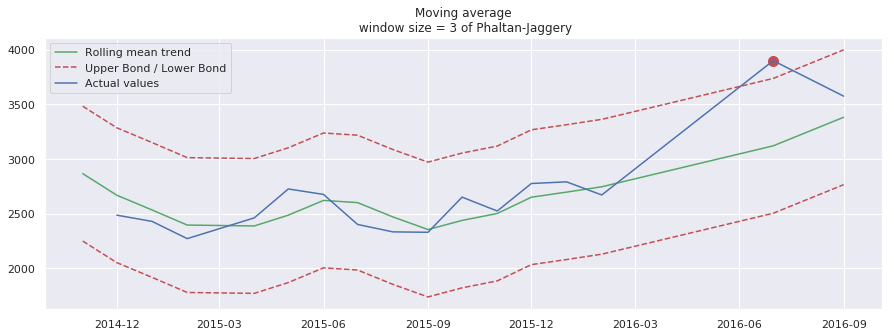

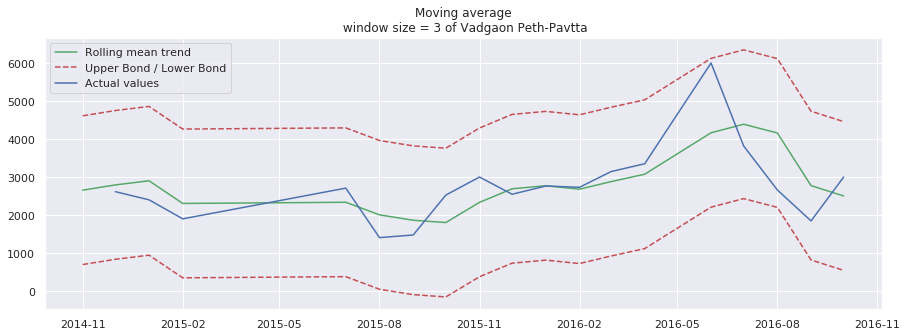

In [331]:
smooth_data_and_show_outlier(data,2,'modal_price','MA',3)

Number of outlier found 1
Number of outlier found 1


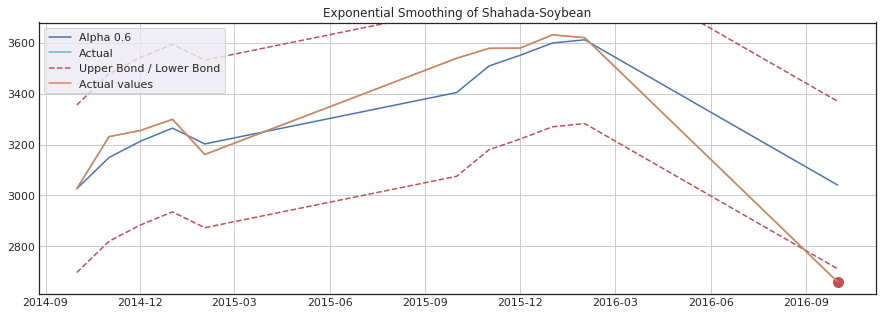

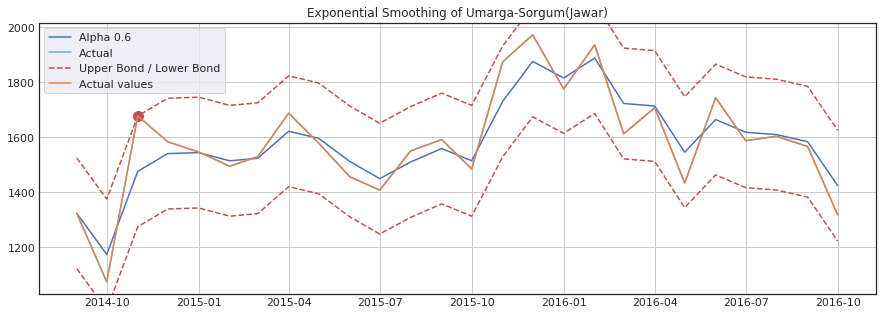

In [220]:
smooth_data_and_show_outlier(data,2,'modal_price','ES',0.6)

In [332]:
def decompose_series(series, frequency, s_window = 'periodic', log = False, boxcox = False, **kwargs):
    '''
    Decompose a time series into seasonal, trend and irregular components using loess, 
    acronym STL.

    params:
        series: a time series

        frequency: the number of observations per “cycle” 
                   (normally a year, but sometimes a week, a day or an hour)

        s_window: either the character string "periodic" or the span 
                 (in lags) of the loess window for seasonal extraction, 
                 which should be odd and at least 7, according to Cleveland 
                 et al.

        log:    boolean.  take log of series

    '''

    df = pd.DataFrame()
    df['date'] = series.index
    if log: 
        series = series.pipe(np.log)
    elif boxcox:
        global series_lambda
        series,series_lambda = stats.boxcox(series)
    s = [x for x in series.values]
    length = len(series)
    s = r.ts(s, frequency=frequency)
    decomposed = [x for x in r.stl(s, s_window).rx2('time.series')]
    df['observed'] = series.values
    df['trend'] = decomposed[length:2*length]
    df['seasonal'] = decomposed[0:length]
    df['residuals'] = decomposed[2*length:3*length]
    df.index = df['date']
    df.drop(['date'],axis=1,inplace=True)
    return df

In [207]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [290]:
robjects.r('''
       tsoutliers <- function(x,plot=FALSE)
{
    x <- as.ts(x)
    if(frequency(x)>1)
        resid <- stl(x,s.window="periodic",robust=TRUE)$time.series[,3]
    else
    {
        tt <- 1:length(x)
        resid <- residuals(loess(x ~ tt))
    }
    resid.q <- quantile(resid,prob=c(0.25,0.75))
    iqr <- diff(resid.q)
    limits <- resid.q + 1.5*iqr*c(-1,1)
    score <- abs(pmin((resid-limits[1])/iqr,0) + pmax((resid - limits[2])/iqr,0))
    if(plot)
    {
        plot(x)
        x2 <- ts(rep(NA,length(x)))
        x2[score>0] <- x[score>0]
        tsp(x2) <- tsp(x)
        points(x2,pch=19,col="red")
        return(invisible(score))
    }
    else
        return(score)
}
        ''')

R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x7f670900d548 / R:0x559c4f536f08>

In [299]:
robjects.r('''
findfreq <- function(x)
{
    n <- length(x)
    spec <- spec.ar(c(x),plot=FALSE)
    if(max(spec$spec)>10) # Arbitrary threshold chosen by trial and error.
    {
        period <- round(1/spec$freq[which.max(spec$spec)])
        if(period==Inf) # Find next local maximum
        {
            j <- which(diff(spec$spec)>0)
            if(length(j)>0)
            {
                nextmax <- j[1] + which.max(spec$spec[j[1]:500])
                period <- round(1/spec$freq[nextmax])
            }
            else
                period <- 1
        }
    }
    else
        period <- 1
    return(period)
}
    ''')

R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x7f67064b4848 / R:0x559c3869a1c8>

In [433]:
def detect_seasonality(data, n, column, apmc=None, commodity=None, decompose = True, freq =12, outliers=True, random_seed=None):
    """
        Visualize commodity for specified apmc
        n : Number of unique commodity and apmc pairs plots to be shown
        columns : columns to be considered for detecting seasonality eg. modal_price
        apmc: specify name of apmc to be plotted
        commodity : specify commodity to be plotted
        decompose : Show time series decomposed into trend, seasonality and noise
        outliers: set it True if you want to detect outliers
        random_seed: set random seed to an integer for reproducible results\ 
    """
    if column in list(data.columns) == False:
        print("Please give valid columns names")
        return
    if n < 0:
        print("n can only be a non-negative integer")
        return
    
    if random_seed:
        np.random.seed(random_seed)
    if apmc and commodity:
        if n>1:
            print("For one particular pair set n=1")
        df = data[(data['APMC']==apmc) & (data['Commodity']==commodity)].sort_index()
        title = apmc + '-' + commodity
        series = data.loc[:,column:column].sort_index()
        series_log = np.log(series)
        s = r.ts(series)
        s_ = np.array(find_seasonality(s))
        s_log = r.ts(series_log)
        s_log = np.array(find_seasonality(s_log))
        if s_[0]>1.0 :
            print("{}-{} has an additive monthly seasonality of {} months".format(apmc,commodity,s_[0]))
        elif s_log[0]>1.0:
            print("{}-{} has a multiplicative monthly seasonality of {} months".format(apmc,commodity,s_log[0]))
        else:
            print("No seasonality detected")
            
        if outliers:
            outlier_series = series[np.array(detect_outliers(s),dtype=bool)]
            if outlier_series.size == 0:
                print("No outlier detected")
            else:
                print("{} outliers detected at \n {}".format(outlier_series.size,outlier_series.index.values))
                
        if decompose:
            df = decompose_series(series,frequency=freq)
            df['trend'].plot()
            df['seasonal'].plot()
            df['residuals'].plot()
            
    else :
        df_grp = data.groupby(['APMC', 'Commodity'])
        a=np.arange(df_grp.ngroups)
        np.random.shuffle(a)
        df = data[df_grp.ngroup().isin(a[:n])]
        df_grp = df.groupby(['APMC', 'Commodity'])
        
        for name, group in df_grp:
            title = name[0] + '-' + name[1]
            group = group.sort_index()
            series = group.loc[:,column:column].sort_index()
            series_log = np.log(series)
            s = r.ts(series)
            s_ = np.array(find_seasonality(s))
            s_log = r.ts(series_log)
            s_log = np.array(find_seasonality(s_log))
            if s_[0]>1.0 and s_log[0]==1.0:
                print("{}-{} has an additive monthly seasonality of {} months".format(name[0],name[1],s_[0]))
            elif s_log[0]>1.0 and s_[0]==1.0:
                print("{}-{} has a multiplicative monthly seasonality of {} months".format(name[0],name[1],s_log[0]))
            elif s_log[0]>1.0 and s_[0]>1.0:
                print("{}-{} has additive seasonality of {} months or multiplicative monthly seasonality of {} months".format(name[0],name[1],s_[0],s_log[0]))
            else:
                print("No seasonality detected in {}-{}".format(name[0],name[1]))
                
            if outliers:
                outlier_series = series[np.array(detect_outliers(s),dtype=bool)]
            if outlier_series.size == 0:
                print("No outlier detected")
            else:
                print("{} outliers detected at \n {}".format(outlier_series.size,outlier_series.index.values))
                
            if decompose:
                df = decompose_series(series,frequency=freq)
                with plt.style.context('seaborn-white'):    
                    plt.figure(figsize=(15, 7))
                    plt.plot(df['trend'], label="Trend")
                    plt.plot(df['seasonal'], label = "Seasonal")
                    plt.plot(df['residuals'], label = "Residuals")
                    plt.legend(loc="best")
                    plt.axis('tight')
                    plt.title("Decomposition of {}".format(title))
                    plt.grid(True)
                    plt.show()

No seasonality detected
1 outliers detected at 
 ['2015-04-01T00:00:00.000000000']


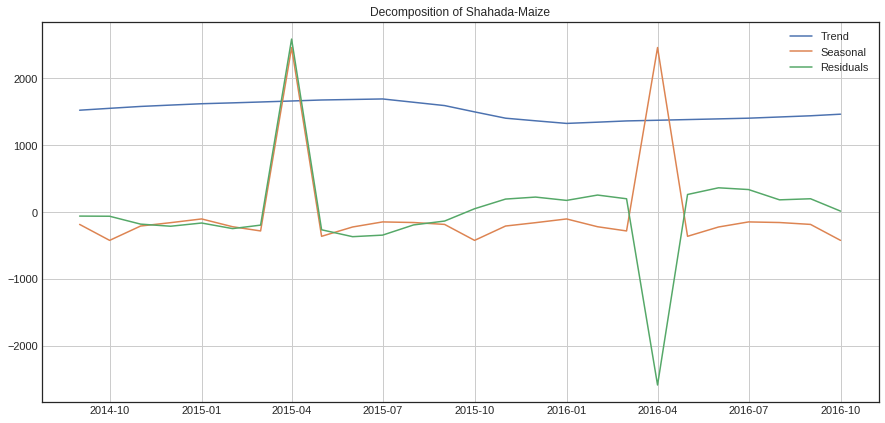

No seasonality detected
No outlier detected


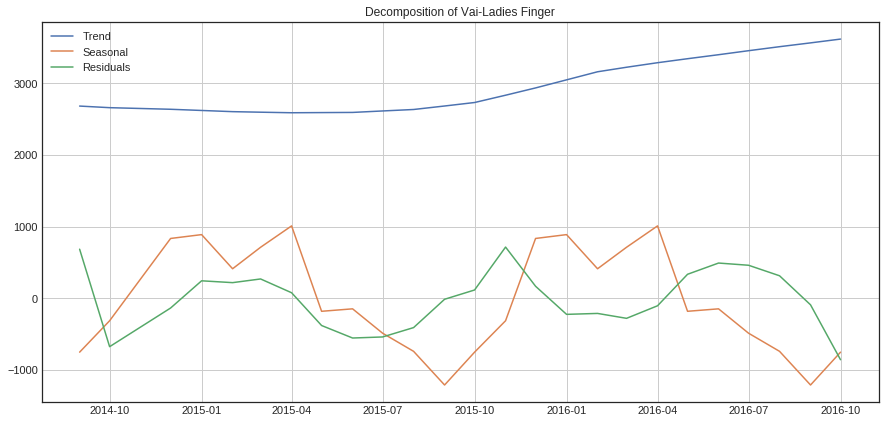

In [355]:
detect_seasonality(data,2,'modal_price')

In [416]:
detect_seasonality(data,2,'modal_price',decompose=False)

Kolhapur-Tomato has an additive monthly seasonality of 6.0 months
1 outliers detected at 
 ['2016-06-01T00:00:00.000000000']
Tumsar-Paddy-Unhusked has an additive monthly seasonality of 13.0 months
No outlier detected


In [447]:
detect_seasonality(data,2,'modal_price',decompose=False)

Mumbai-Orange has an additive monthly seasonality of 8.0 months
No outlier detected
No seasonality detected in Nagpur-Sorgum(Jawar)
No outlier detected


In [458]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [490]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=1):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [491]:
apmc = 'Umarga'
commodity = 'Sorgum(Jawar)'
df = data[(data['APMC']==apmc) & (data['Commodity']==commodity)].sort_index().modal_price
df = df.dropna()

In [492]:
%%time

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(df, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(df, slen = 1, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 1, scaling_factor = 3)
model.triple_exponential_smoothing()

0.4850894331287676 0.2956198619648983 0.2887022476182429
CPU times: user 508 ms, sys: 85 µs, total: 508 ms
Wall time: 516 ms


In [493]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

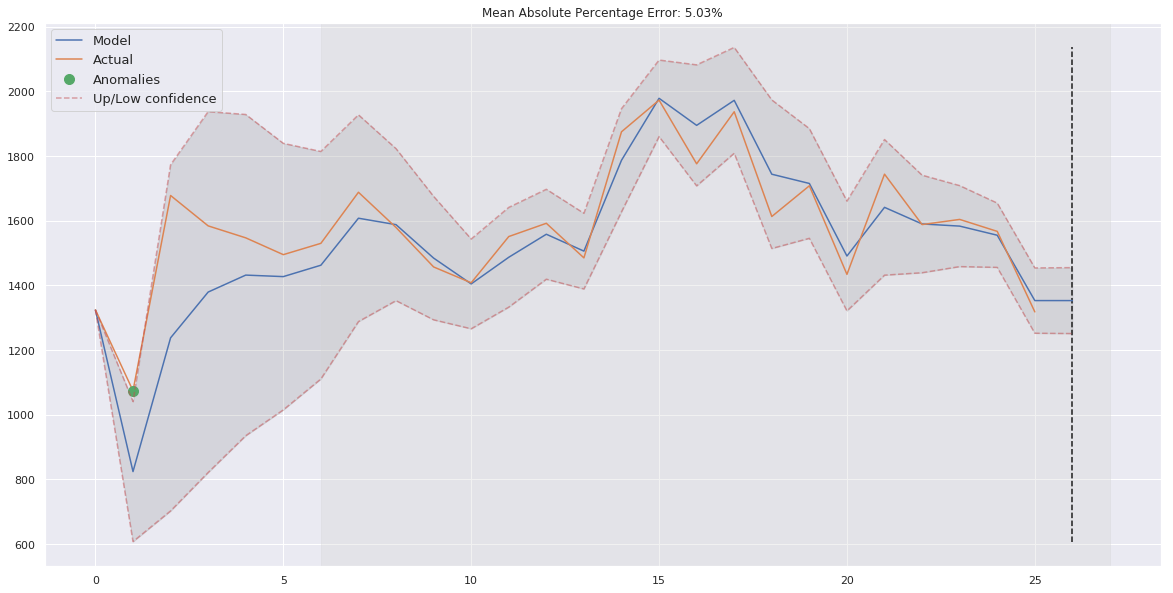

In [495]:
plotHoltWinters(df,plot_intervals=True, plot_anomalies=True)

In [497]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

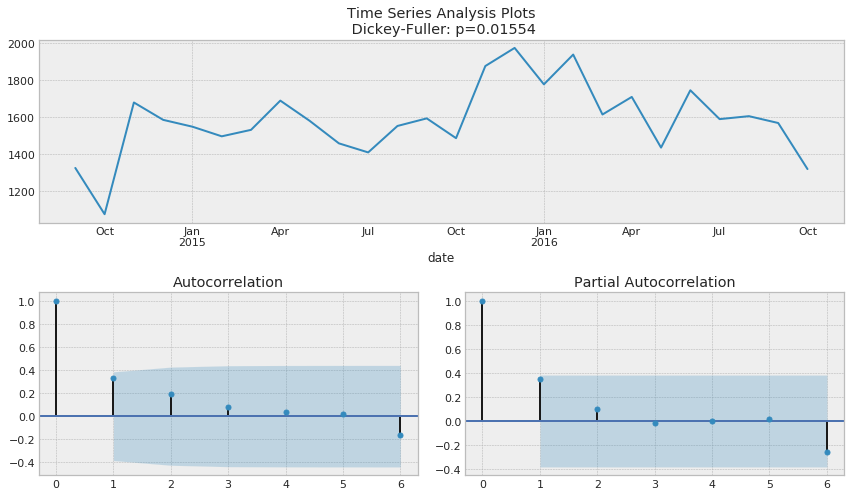

In [500]:
tsplot(df, lags=6)